# Modelling

In [3]:
import pandas as pd
import numpy as np

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt

In [103]:
def npv_score(y_test, y_pred):
    true_negatives = np.unique(np.array(list(zip(y_test.values, y_pred))).sum(axis=1), return_counts=True)[1][0]
    predicted_negatives = np.unique(y_pred, return_counts=True)[1][0]
    npv = true_negatives / predicted_negatives
    return npv

In [5]:
df = pd.read_csv("data/games_with_features.csv", index_col="id")

In [6]:
df.head()

,date,home_team_score,period,postseason,season,status,visitor_team_score,home_team.id,home_team.abbreviation,home_team.conference,...,visitor_team.full_name,winner,home_team_avg_score_historical,visitor_team_avg_score_historical,home_team_id_year,visitor_team_id_year,home_team_avg_score,visitor_team_avg_score,home_avg_score_diff,visitor_avg_score_diff
id,,,,,,,,,,,,,,,,,,,,,
47179,2019-01-30,126,4,False,2018,Final,94,2,BOS,East,...,Charlotte Hornets,1,105.8,98.2,2 2018,4 2018,112.8,108.3,3.620000,-3.831707
48751,2019-02-09,112,4,False,2018,Final,123,2,BOS,East,...,LA Clippers,0,105.8,100.7,2 2018,13 2018,112.8,113.1,3.620000,0.581818
48739,2019-02-08,117,4,False,2018,Final,110,23,PHI,East,...,Denver Nuggets,1,103.3,104.2,23 2018,8 2018,117.9,108.2,8.725532,-4.670213
48740,2019-02-08,119,4,False,2018,Final,106,30,WAS,East,...,Cleveland Cavaliers,1,103.4,98.3,30 2018,6 2018,116.4,103.8,7.429268,-8.419512
48746,2019-02-08,102,4,False,2018,Final,96,26,SAC,West,...,Miami Heat,1,105.5,96.0,26 2018,16 2018,114.9,105.4,5.129268,-6.670732


### Ultra Baseline

In [7]:
# predict winner only using home_team_avg_score when playing at home
# vs visitor_team_avg_score when playing as visitor
home_should_win = df[df["home_team_avg_score"].gt(df["visitor_team_avg_score"])]
home_should_win["winner"].value_counts(normalize=True)

1    0.664878
0    0.335122
Name: winner, dtype: float64

In [8]:
s2018 = df[df["season"].eq(2018)]
# predict winner only using home_team_avg_score when playing at home
# vs visitor_team_avg_score when playing as visitor
home_should_win = s2018[s2018["home_team_avg_score"].gt(s2018["visitor_team_avg_score"])]
home_should_win["winner"].value_counts(normalize=True)

1    0.669248
0    0.330752
Name: winner, dtype: float64

> Home team wins 66% of the time when their avg score is higher   
> there is a flaw with this baseline in that it uses the average score from all games   
> that occured that season and correlates it with the winner of games that occured before   
> that average score was known

In [9]:
df[(df["home_team_avg_score"] - 5).gt(df["visitor_team_avg_score"])]["winner"].value_counts(normalize=True)

1    0.717187
0    0.282813
Name: winner, dtype: float64

> same experiment as above but only using teams that are heavy favourites (10 pt average more).  
> win percantage seems to increse 1% per 1pt advantage

In [10]:
s2020 = df[df["season"].eq(2020)]
s2019 = df[df["season"].eq(2019)]
s2018 = df[df["season"].eq(2018)]
s2017 = df[df["season"].eq(2017)]
s2016 = df[df["season"].eq(2016)]
s2015 = df[df["season"].eq(2015)]

### Baseline

In [11]:
lr = LogisticRegression(max_iter=1000)
nb = GaussianNB()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False)

models = [lr, nb, knn, rf, xgb]

In [12]:
def train_model(model, train_data, test_data):
    X_train = train_data.drop("winner", axis=1)
    y_train = train_data["winner"]
    X_test = test_data.drop("winner", axis=1)
    y_test = test_data["winner"]                     

    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(accuracy_score(y_test, y_pred))
    #print(cross_val_score(model, feats, target).mean())

In [13]:
train_data = df[df["season"].isin([2017])][["home_team_avg_score", "visitor_team_avg_score", "winner"]]
test_data = df[df["season"].isin([2018])][["home_team_avg_score", "visitor_team_avg_score", "winner"]]
for model in models:
    train_model(model, train_data, test_data)

0.6399694889397407
0.6414950419527079
0.5713196033562167
0.5530129672006102
0.5408085430968727


#### using score diff feat

In [14]:
features = ["winner", "home_team_avg_score", "visitor_team_avg_score", "home_avg_score_diff", "visitor_avg_score_diff"]
train_data = df[df["season"].isin(range(2015,2018))][features]
test_data = df[df["season"].isin([2018])][features]
for model in models:
    train_model(model, train_data, test_data)

0.6361556064073226
0.6376811594202898
0.566742944317315
0.6064073226544623
0.5881006864988558


> xgboost and random forest predict around 80% correctly when using data from the same season.  
> unfortunately when trying to predict results of future seasons the result is horrible.

##### The Big problem with this so far is that averages for the season are used to predict outcomes of games that contributed to those averages

### 2020 stats with test info leaking into train set

In [15]:
stats = pd.read_csv("data/stats_feats2020.csv", index_col="game_id")

In [16]:
X = stats.drop(["winner", "game_date", "season"], axis=1)
y = stats["winner"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

for model in models:
    model = model
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(model)
    print(accuracy_score(y_train, y_train_pred))
    print(accuracy_score(y_test, y_pred))
    print(cross_val_score(model, X_test, y_test).mean())

LogisticRegression(max_iter=1000)
0.8137603795966786
0.8156028368794326
0.8152882205513784
GaussianNB()
0.7663107947805456
0.7624113475177305
0.7197994987468672
KNeighborsClassifier()
0.8054567022538552
0.7127659574468085
0.6771303258145364
RandomForestClassifier()
1.0
0.74822695035461
0.7197994987468672
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
1.0
0.7624113475177305
0.7199874686716792


> this seems to good to be true   

## Using stats from 2015 - 2020

In [17]:
lr = LogisticRegression(max_iter=1000)
nb = GaussianNB()
knn = KNeighborsClassifier()
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators=100, eval_metric="logloss", use_label_encoder=False)

models = [lr, nb, knn, rf, xgb]

In [18]:
stats = pd.read_csv("data/stats_feats.csv", index_col="game_id")

In [19]:
X = stats.drop(["winner", "game_date", "season"], axis=1)
y = stats["winner"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

for model in models:
    model = model
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(model)
    print(accuracy_score(y_train, y_train_pred))
    print(accuracy_score(y_test, y_pred))
    print(cross_val_score(model, X_test, y_test).mean())

/Users/zacharyargentin/opt/anaconda3/envs/bootcamp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)
0.6237070748862226
0.630272952853598


/Users/zacharyargentin/opt/anaconda3/envs/bootcamp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zacharyargentin/opt/anaconda3/envs/bootcamp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

0.6321250697075169
GaussianNB()
0.5798510550268928
0.5905707196029777
0.5843701324923563
KNeighborsClassifier()
0.7254861398427803
0.5843672456575683
0.560784954714151
RandomForestClassifier()
1.0
0.6253101736972705
0.5893179239659251
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
0.9985519238725693
0.6172456575682382
0.583124050535546


> The test data is no longer leaking into the training data. But the model still overfits

In [20]:
train = stats[stats["season"].isin([2015,2016,2017,2018,2019])]
test = stats[stats["season"].eq(2020)]

In [21]:
X_train = train.drop(["winner", "game_date", "season"], axis=1)
y_train = train["winner"]
X_test = test.drop(["winner", "game_date", "season"], axis=1)
y_test = test["winner"]

In [22]:
for model in models:
    model = model
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(model)
    print(accuracy_score(y_train, y_train_pred))
    print(accuracy_score(y_test, y_pred))
    print(cross_val_score(model, X_test, y_test).mean())

LogisticRegression(max_iter=1000)
0.6329042029534268
0.570446735395189


/Users/zacharyargentin/opt/anaconda3/envs/bootcamp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zacharyargentin/opt/anaconda3/envs/bootcamp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

0.5936214296285334
GaussianNB()
0.5921999242711095
0.5231958762886598
0.5876461447387894
KNeighborsClassifier()
0.733434305187429
0.5137457044673539
0.5464148290661536
RandomForestClassifier()
1.0
0.5231958762886598
0.5790476542844457
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
0.9986747444149944
0.5223367697594502
0.5567152582507029


## Using all stats

In [37]:
lr = LogisticRegression(max_iter=5000)
nb = GaussianNB()
knn = KNeighborsClassifier()
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators=100, eval_metric="logloss", use_label_encoder=False)

models = [lr, nb, knn, rf, xgb]

In [24]:
stats = pd.read_csv("data/all_stats_feats.csv", index_col="game_id")

In [25]:
X = stats.drop(["winner", "game_date", "season"], axis=1)
y = stats["winner"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

for model in models:
    model = model
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(model)
    print(accuracy_score(y_train, y_train_pred))
    print(accuracy_score(y_test, y_pred))
    print(cross_val_score(model, X_test, y_test).mean())

LogisticRegression(max_iter=1000)
0.6334298717418287
0.6209677419354839


/Users/zacharyargentin/opt/anaconda3/envs/bootcamp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zacharyargentin/opt/anaconda3/envs/bootcamp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

0.6141280310751303
GaussianNB()
0.5806785270997104
0.5936724565756824
0.575059131203969
KNeighborsClassifier()
0.7287960281340504
0.5787841191066998
0.5533392304290138
RandomForestClassifier()
1.0
0.607940446650124
0.6004961252235448
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
0.9985519238725693
0.5949131513647643
0.5843797473222698


In [122]:
train = stats[stats["season"].lt(2020)]
test = stats[stats["season"].eq(2020)]

In [123]:
X_train = train.drop(["winner", "game_date", "season"], axis=1)
y_train = train["winner"]
X_test = test.drop(["winner", "game_date", "season"], axis=1)
y_test = test["winner"]

In [124]:
# using only diff
X_train = X_train.loc[:,"diff_away_ast":]
X_test = X_test.loc[:,"diff_away_ast":]

In [125]:
for model in models:
    model = model
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(model)
    print(accuracy_score(y_train, y_train_pred))
    print(accuracy_score(y_test, y_pred))
    print(precision_score(y_test, y_pred))
    print(recall_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

LogisticRegression(max_iter=5000)
0.6185157137447936
0.5747422680412371
0.5902688860435339
0.7248427672955975
[[208 320]
 [175 461]]
GaussianNB()
0.5808405906853464
0.5567010309278351
0.5742574257425742
0.7295597484276729
[[184 344]
 [172 464]]
KNeighborsClassifier()
0.7288905717531238
0.5042955326460481
0.5439642324888226
0.5738993710691824
[[222 306]
 [271 365]]
RandomForestClassifier()
1.0
0.538659793814433
0.558858501783591
0.7389937106918238
[[157 371]
 [166 470]]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weig

> More data slightly improved random forest and XGboost algos.   
> Some models overfit so possibly hyper parameter tuning would help?   
> But I think we need to be more selective of features / engineer better featrures

### best_model

In [126]:
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(npv_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.6185157137447936
0.5747422680412371
0.5902688860435339
0.5430809399477807
[[208 320]
 [175 461]]


<Figure size 640x480 with 0 Axes>

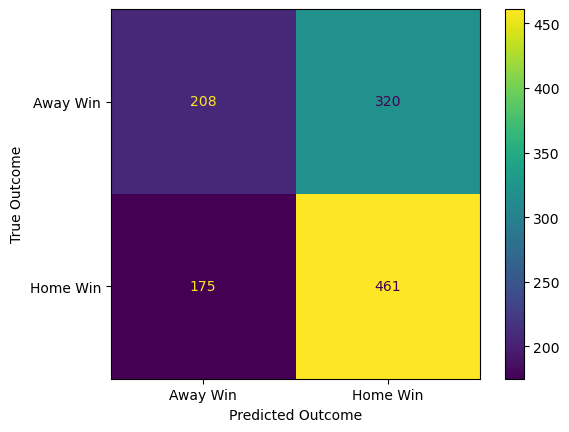

In [127]:
plt.figure()
plot_confusion_matrix(lr, X_test, y_test)
plt.ylabel("True Outcome")
plt.yticks(ticks=[0,1], labels=["Away Win", "Home Win"])
plt.xticks(ticks=[0,1], labels=["Away Win", "Home Win"])
plt.xlabel("Predicted Outcome")
plt.show()

In [115]:
176/311

0.5659163987138264